In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy.linalg as npl
np.set_printoptions(precision=2)

In [11]:
# generate data - M dimensions, N samples
N = 20
M = 2

np.random.seed(2)
X = np.random.randint(0, 20, N*M).astype(float)
X = X.reshape((N,M)) # NXM
X -= np.mean(X) # center
D = np.array([[npl.norm(X[i]-X[j]) for i in range(N)] for j in range(N)])
K = X@X.T # MXM
# print(D)

imap = {} # map array index to matrix index
i = 0
d = np.array([])
for r in range(N):
    for c in range(r+1, N):
        imap[i] = (r, c)
        d = np.append(d, D[r,c])
        i += 1
        
idx = np.argsort(d)
d = d[idx]
d, unique_idx = np.unique(d, return_index=True)
idx = idx[unique_idx]
# print(d)

S = [imap[idx[i]] + imap[idx[i+1]] for i in range(len(idx)-1)]
# print(S)

In [28]:
# inequality constraints
A = []
for (i,j,k,l) in S:
    a = np.zeros((N,N))
    a[k,k] += 1
    a[k,l] += -2
    a[l,l] += 1
    a[i,i] += -1
    a[i,j] += 2
    a[j,j] += -1
    A.append(a)
    
K_ = cp.Variable((N,N), symmetric=True) # gram matrix
E = cp.Variable((len(S),1), nonneg=True) # slack

diff = d[1]-d[0] # force difference between comparisons
gamma = 0.5 # reg param for rank

constraints = []
constraints += [K_ >> 0] # PSD
constraints += [cp.sum(K_) == 0] # center
constraints += [cp.trace(A[e]@K_) >= (diff - E[e]) for e in range(len(S))]

prob = cp.Problem(cp.Minimize(cp.sum(E) + gamma*cp.trace(K_)), constraints)
# prob = cp.Problem(cp.Minimize(cp.sum(E)), constraints)
prob.solve()

33.60396257929778

In [29]:
np.array([constraints[i].value() for i in range(2,len(S))]).T

array([ True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True, False,  True, False, False,
        True, False, False, False, False, False, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True,  True, False, False, False, False, False,
        True,  True, False, False, False,  True, False,  True, False,
       False])

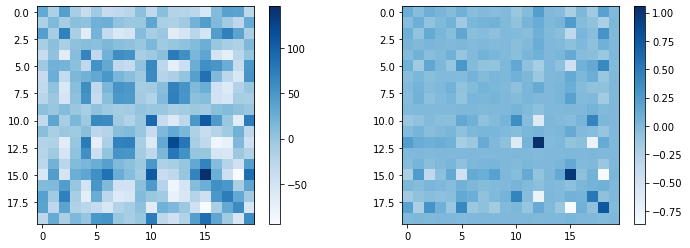

In [30]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(K, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();
plt.subplot(122)
plt.imshow(K_.value, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

In [31]:
U, V = npl.eigh(K_.value)

print(npl.eigh(K)[0])
print(npl.eigh(K_.value)[0])

U = U[-M:]
V = V[-M:]

x1 = X
x2 = (np.diag(U**0.5)@V).T

# rescale?
# U *= np.sqrt(np.sum(npl.eigh(K)[0][-2:]**2))/np.sqrt(np.sum(U**2))
X_ = (np.diag(U**0.5)@V).T # NxM

print(npl.eigh(K)[0][-2:])
print(U)

[-1.18e-13 -3.13e-14 -2.41e-14 -2.36e-14 -1.25e-14 -7.85e-15 -4.62e-15
 -2.35e-15  2.71e-16  8.17e-16  2.50e-15  4.60e-15  5.05e-15  1.07e-14
  1.45e-14  2.39e-14  6.94e-14  1.20e-13  5.44e+02  5.62e+02]
[-2.93e-05 -2.54e-05 -2.05e-05 -1.61e-05 -9.33e-06 -4.71e-06 -2.48e-06
  3.03e-09  5.99e-07  3.46e-06  3.88e-06  5.92e-06  1.02e-05  1.12e-05
  1.31e-05  1.86e-05  2.64e-05  1.09e-01  2.09e+00  2.36e+00]
[543.86 562.12]
[2.09 2.36]


In [32]:
# plt.figure(figsize=(12,4))
# plt.subplot(121)
# plt.plot(X[:,0], X[:,1], 'C0.')
# plt.subplot(122)
# plt.plot(X_[:,0], X_[:,1], 'C1.')

In [33]:
# new distance matrix
D_ = np.array([[npl.norm(X_[i]-X_[j]) for i in range(N)] for j in range(N)])

# is order preserved
before = np.zeros(len(S))
after = np.zeros(len(S))
for s in range(len(S)):
    i,j,k,l = S[s]
    before[s] = D[i,j] <= D[k,l]
    after[s] = D_[i,j] <= D_[k,l]

# fraction of orderings preserved
preserved = (len(S) - np.count_nonzero(before-after))/len(S)
print(preserved)
print(before)
print(after)

0.5
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0.]


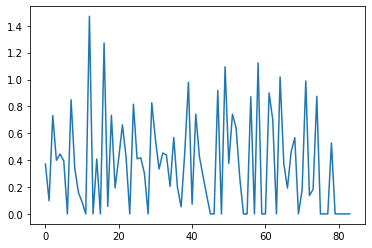

In [34]:
plt.plot(E.value.reshape(-1))